# Zeitreihenprognose für den Aktienmarkt mit mehreren Ansätzen

In diesem Notebook verwenden wir historische Aktienmarktdaten von Apple Inc. (AAPL), die aus einer lokalen CSV-Datei (`HistoricalQuotes.csv`) geladen wurden, um verschiedene Methoden zur Zeitreihenprognose zu demonstrieren. Wir werden den Schlusskurs des nächsten Tages mit unterschiedlichen Ansätzen vorhersagen – angefangen von den einfachsten bis hin zu fortgeschritteneren Methoden.

Nachfolgend sind die Prognoseansätze aufgeführt, die wir behandeln werden:

1. **Naive Prognose:** Die einfachste Methode, die annimmt, dass der nächste Wert gleich dem zuletzt beobachteten Wert ist.
2. **Autoregressive (AR)-Prognose:** Prognose unter Verwendung des Durchschnitts der letzten *k* Beobachtungen (hier: *k* = 3).
3. **Exponentielle Glättung:** Ein gewichteter Durchschnitt vergangener Beobachtungen, bei dem neuere Werte stärker gewichtet werden.
4. **Linearer Trend:** Anpassung eines linearen Modells (ein Spezialfall der linearen Regression), um den Trend zu erfassen.
5. **Multiple lineare Regression:** Erweiterung des linearen Trendmodells durch Einbeziehung zusätzlicher Merkmale wie Handelsvolumen und gleitender Durchschnitte.

Die mathematischen Formulierungen der Methoden lauten wie folgt:

### Naive Prognose

Es wird angenommen, dass der nächste Wert dem zuletzt beobachteten Wert entspricht:

$$ y_{t+1} = y_t $$

### Autoregressive (AR)-Prognose

Für ein einfaches AR(3)-Modell:

$$ y_{t+1} = \frac{y_t + y_{t-1} + y_{t-2}}{3} $$

### Exponentielle Glättung

Die Prognose wird berechnet als:

$$ F_{t+1} = \alpha y_t + (1-\alpha) F_t $$

mit dem Glättungsfaktor $\alpha$ (0 < $\alpha$ < 1).

### Linearer Trend

Ein einfaches lineares Trendmodell nimmt an:

$$ y_t = a + b\,t $$

was ein Spezialfall der linearen Regression ist, bei der die Zeit die einzige unabhängige Variable darstellt.

### Multiple lineare Regression

Wir erweitern das lineare Modell, um zusätzliche Prädiktoren einzubeziehen. Zum Beispiel:

$$ y_t = \beta_0 + \beta_1\,t + \beta_2\,V_t + \beta_3\,MA_t + \epsilon_t $$

wobei $ V_t $ das Handelsvolumen und $ MA_t $ ein gleitender Durchschnitt des Schlusskurses ist. Die Koeffizienten $\beta$ werden mittels der Methode der kleinsten Quadrate geschätzt:

$$ \beta = (X^T X)^{-1} X^T y $$

Lassen Sie uns nun mit der Implementierung fortfahren.

In [1]:
import numpy as np
import pandas as pd

# Setze ein Anzeigeformat für Fließkommazahlen
pd.options.display.float_format = '{:.2f}'.format

## 1. Laden und Aufbereiten der Daten

Wir laden die historischen AAPL-Aktienmarktdaten aus einer lokalen CSV-Datei (`HistoricalQuotes.csv`). Dieser Datensatz enthält tägliche Daten wie Open, High, Low, Close, Adj Close und Volume. In diesem Beispiel verwenden wir die **Close**-Spalte für unsere Analyse.

Folgende Schritte werden durchgeführt:

- Entfernen von zusätzlichen Leerzeichen in den Spaltennamen
- Umbenennen der Spalte `Close/Last` in `Close`
- Entfernen von Dollarzeichen aus numerischen Spalten und Umwandlung in Fließkommazahlen
- Umwandlung der Spalte `Volume` in Ganzzahlen
- Parsen der Spalte `Date` als Datum und Setzen als Index

In [2]:
dataset_path = "HistoricalQuotes.csv"

# Lese die CSV-Daten ein und parse die 'Date'-Spalte als Datum
df = pd.read_csv(dataset_path, parse_dates=['Date'])

# Entferne führende und nachfolgende Leerzeichen aus den Spaltennamen
df.columns = df.columns.str.strip()

# Benenne 'Close/Last' in 'Close' um
df.rename(columns={'Close/Last': 'Close'}, inplace=True)

# Entferne Dollarzeichen und wandle die folgenden Spalten in Fließkommazahlen um
cols_to_convert = ["Close", "Open", "High", "Low"]
df[cols_to_convert] = df[cols_to_convert].replace({'\$': ''}, regex=True).astype(float)

# Wandle 'Volume' in Ganzzahlen um
df["Volume"] = df["Volume"].astype(int)

# Setze 'Date' als Index
df.set_index('Date', inplace=True)

# Sortiere den Index in aufsteigender Reihenfolge
df = df.sort_index()

# Zeige die ersten paar Zeilen an
df.head()

,Close,Volume,Open,High,Low
Date,,,,,
2010-03-01,29.86,137312041,29.39,29.93,29.35
2010-03-02,29.84,141486282,29.99,30.12,29.68
2010-03-03,29.90,92846488,29.85,29.98,29.71
2010-03-04,30.10,89591907,29.90,30.13,29.80
2010-03-05,31.28,224647427,30.71,31.39,30.66


## 2. Visualisierung der Daten

Lassen Sie uns den täglichen Schlusskurs plotten, um einen ersten Eindruck von den Daten zu bekommen.

Text(0, 0.5, 'Schlusskurs')

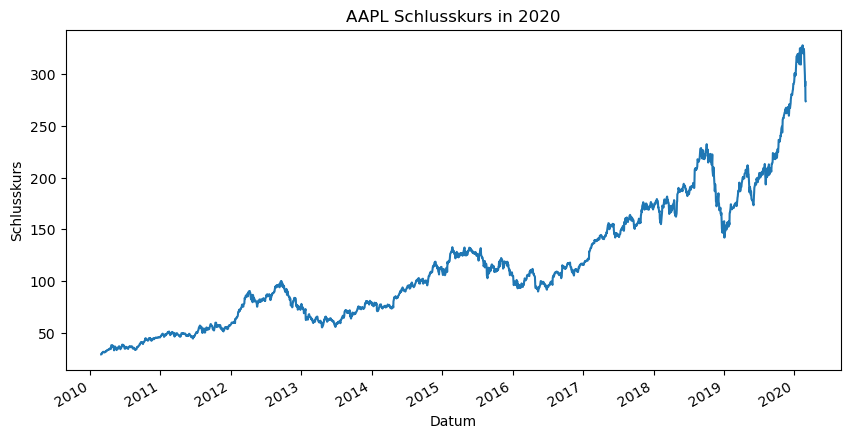

In [3]:
# Plotte den Schlusskurs
ax = df['Close'].plot(title='AAPL Schlusskurs in 2020', figsize=(10, 5))
ax.set_xlabel('Datum')
ax.set_ylabel('Schlusskurs')

## 3. Prognoseansätze

Wir implementieren nun mehrere Prognoseansätze. Wir beginnen mit der einfachsten Methode und gehen zu fortgeschritteneren Ansätzen über.

### 3.1 Naive Prognose

Die **Naive Prognose** verwendet einfach den Schlusskurs des vorherigen Tages als Prognose für den nächsten Tag. Mathematisch:

$$ y_{t+1} = y_t $$

Diese Methode ist einfach umzusetzen und dient als Benchmark für anspruchsvollere Methoden.

In [18]:
# Erstelle eine Kopie der Daten für die naive Prognose
df_naive = df.copy()

# Verschiebe die 'Close'-Spalte um eine Zeile nach unten, um die naive Prognose zu erhalten
df_naive['Naive Forecast'] = df_naive['Close'].shift(1)

df_naive.head(6)

,Close,Volume,Open,High,Low,Naive Forecast
Date,,,,,,
2010-03-01,29.86,137312041,29.39,29.93,29.35,NaN
2010-03-02,29.84,141486282,29.99,30.12,29.68,29.86
2010-03-03,29.90,92846488,29.85,29.98,29.71,29.84
2010-03-04,30.10,89591907,29.90,30.13,29.80,29.90
2010-03-05,31.28,224647427,30.71,31.39,30.66,30.10
2010-03-08,31.30,107326832,31.43,31.44,31.18,31.28


### 3.2 Autoregressive (AR)-Prognose

Die **Autoregressive Prognose** (AR) verwendet den Durchschnitt der Schlusskurse der letzten 3 Tage, um den Schlusskurs des nächsten Tages vorherzusagen. Das Modell lautet:

$$ y_{t+1} = \frac{y_t + y_{t-1} + y_{t-2}}{3} $$

Dieser einfache Durchschnitt kann als ein grundlegendes AR(3)-Modell betrachtet werden.

In [ ]:
# Definiere die autoregressive Vorhersagefunktion mit einer Verzögerung (Lag) von 3
def autoregression_predict(data, lag=3):
    """
    Sagt den nächsten Wert als Durchschnitt der letzten 'lag' Werte voraus.
    """
    return np.mean(data[-lag:])

# Extrahiere die Schlusskurse
close_prices = df['Close'].values

# Setze den Lag-Wert
lag = 3
ar_predictions = []

# Schleife über die Daten, beginnend beim Index 'lag'
for i in range(lag, len(close_prices)):
    past_values = close_prices[i-lag:i]
    pred = autoregression_predict(past_values, lag=lag)
    ar_predictions.append(pred)

# Erstelle ein neues DataFrame für die AR-Prognose (verfügbar ab der 'lag'-ten Beobachtung)
df_ar = df.iloc[lag:].copy()
df_ar['AR Forecast'] = ar_predictions

df_ar.head(10)

,Close,Volume,Open,High,Low,AR Forecast
Date,,,,,,
2010-03-04,30.10,89591907,29.90,30.13,29.80,29.87
2010-03-05,31.28,224647427,30.71,31.39,30.66,29.95
2010-03-08,31.30,107326832,31.43,31.44,31.18,30.43
2010-03-09,31.86,229908139,31.19,32.14,31.13,30.89
2010-03-10,32.12,148907755,31.98,32.21,31.89,31.48
2010-03-11,32.21,101209110,31.99,32.21,31.90,31.76
2010-03-12,32.37,103841951,32.48,32.53,32.25,32.06
2010-03-15,31.98,123005437,32.20,32.21,31.46,32.24
2010-03-16,32.06,111581993,32.03,32.14,31.79,32.19


### 3.3 Exponentielle Glättung

Die **Exponentielle Glättung** berechnet einen gewichteten Durchschnitt vergangener Beobachtungen, wobei neuere Werte stärker gewichtet werden. Die Prognoseformel lautet:

$$ F_{t} = \alpha y_{t-1} + (1-\alpha) F_{t-1} $$

wobei $\alpha$ der Glättungsfaktor ist. In diesem Beispiel verwenden wir $\alpha = 0.5$.

In [6]:
# Definiere die Funktion für exponentielle Glättung
def exponential_smoothing(series, alpha):
    forecasts = [series[0]]  # Die anfängliche Prognose ist die erste Beobachtung
    for t in range(1, len(series)):
        forecast = alpha * series[t-1] + (1 - alpha) * forecasts[-1]
        forecasts.append(forecast)
    return np.array(forecasts)

# Setze den Glättungsfaktor alpha
alpha = 0.5
exp_smooth_forecasts = exponential_smoothing(close_prices, alpha)

# Erstelle ein DataFrame für die exponentielle Glättungsprognose
df_exp = df.copy()
df_exp['Exp Smooth Forecast'] = exp_smooth_forecasts

df_exp.head(10)

,Close,Volume,Open,High,Low,Exp Smooth Forecast
Date,,,,,,
2010-03-01,29.86,137312041,29.39,29.93,29.35,29.86
2010-03-02,29.84,141486282,29.99,30.12,29.68,29.86
2010-03-03,29.90,92846488,29.85,29.98,29.71,29.85
2010-03-04,30.10,89591907,29.90,30.13,29.80,29.88
2010-03-05,31.28,224647427,30.71,31.39,30.66,29.99
2010-03-08,31.30,107326832,31.43,31.44,31.18,30.63
2010-03-09,31.86,229908139,31.19,32.14,31.13,30.97
2010-03-10,32.12,148907755,31.98,32.21,31.89,31.41
2010-03-11,32.21,101209110,31.99,32.21,31.90,31.77


### 3.4 Linearer Trend

Beim **Linearen Trend** nehmen wir an, dass die Daten durch eine lineare Beziehung modelliert werden können:

$$ y_t = a + b\,t $$

Wir verwenden NumPys `polyfit`-Funktion, um eine Gerade an die Daten anzupassen, und nutzen das resultierende lineare Modell, um Prognosen zu erstellen.

In [24]:
# Erstelle einen Zeitindex für die Daten
days = np.arange(len(close_prices))

# Passe ein lineares Modell (Polynom 1. Grades) an
coeff = np.polyfit(days, close_prices, deg=5)
linear_model = np.poly1d(coeff)

# Berechne die Prognose des linearen Trends
linear_predictions = linear_model(days)

# Erstelle ein DataFrame für die lineare Trendprognose
df_linear = df.copy()
df_linear['Linear Trend Forecast'] = linear_predictions

df_linear.head(10)

,Close,Volume,Open,High,Low,Linear Trend Forecast
Date,,,,,,
2010-03-01,29.86,137312041,29.39,29.93,29.35,22.94
2010-03-02,29.84,141486282,29.99,30.12,29.68,23.12
2010-03-03,29.90,92846488,29.85,29.98,29.71,23.30
2010-03-04,30.10,89591907,29.90,30.13,29.80,23.48
2010-03-05,31.28,224647427,30.71,31.39,30.66,23.66
2010-03-08,31.30,107326832,31.43,31.44,31.18,23.84
2010-03-09,31.86,229908139,31.19,32.14,31.13,24.02
2010-03-10,32.12,148907755,31.98,32.21,31.89,24.19
2010-03-11,32.21,101209110,31.99,32.21,31.90,24.37


## 4. Vergleich der Prognoseansätze

Wir kombinieren nun die Prognosen aller Ansätze in einem einzigen DataFrame und visualisieren sie zusammen mit den tatsächlichen Schlusskursen. Beachten Sie, dass die AR-Prognose erst ab dem Index verfügbar ist, der dem gewählten Lag entspricht (d.h. ab der 4. Beobachtung).

In [25]:
# Kombiniere alle Prognosen in einem DataFrame
df_combined = df.copy()

# Füge die Naive Prognose hinzu
df_combined['Naive Forecast'] = df_combined['Close'].shift(1)

# Füge die AR-Prognose hinzu (die ersten Zeilen bleiben NaN)
df_combined['AR Forecast'] = np.nan
df_combined.iloc[lag:, df_combined.columns.get_loc('AR Forecast')] = ar_predictions

# Füge die exponentielle Glättungsprognose hinzu
df_combined['Exp Smooth Forecast'] = exp_smooth_forecasts

# Füge die lineare Trendprognose hinzu
df_combined['Linear Trend Forecast'] = linear_predictions

df_combined.head(15)

,Close,Volume,Open,High,Low,Naive Forecast,AR Forecast,Exp Smooth Forecast,Linear Trend Forecast
Date,,,,,,,,,
2010-03-01,29.86,137312041,29.39,29.93,29.35,NaN,NaN,29.86,22.94
2010-03-02,29.84,141486282,29.99,30.12,29.68,29.86,NaN,29.86,23.12
2010-03-03,29.90,92846488,29.85,29.98,29.71,29.84,NaN,29.85,23.30
2010-03-04,30.10,89591907,29.90,30.13,29.80,29.90,29.87,29.88,23.48
2010-03-05,31.28,224647427,30.71,31.39,30.66,30.10,29.95,29.99,23.66
2010-03-08,31.30,107326832,31.43,31.44,31.18,31.28,30.43,30.63,23.84
2010-03-09,31.86,229908139,31.19,32.14,31.13,31.30,30.89,30.97,24.02
2010-03-10,32.12,148907755,31.98,32.21,31.89,31.86,31.48,31.41,24.19
2010-03-11,32.21,101209110,31.99,32.21,31.90,32.12,31.76,31.77,24.37


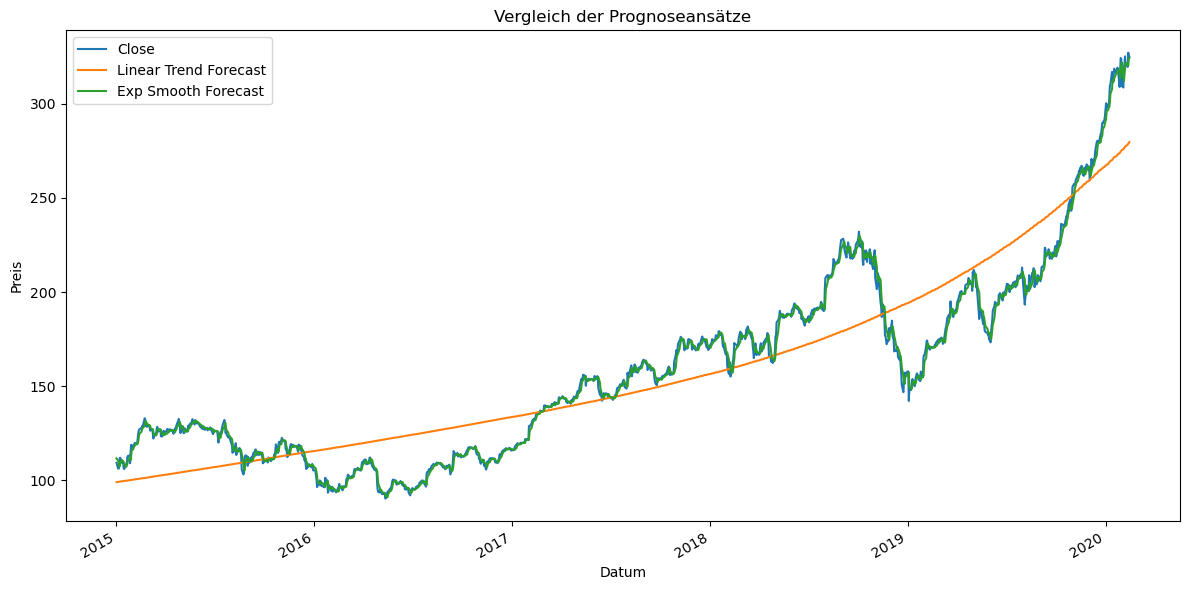

In [26]:
# Plotte alle Prognoseansätze zusammen mit dem tatsächlichen Schlusskurs
start_date = '2015-01-01'
end_date = '2020-02-15'

ax = df_combined.loc[start_date:end_date, ["Close", 
                                          #  "Naive Forecast", 
                                          #  "AR Forecast",
                                           "Linear Trend Forecast",  # Kommentiere diese Zeile aus, um den linearen Trend zu sehen
                                           "Exp Smooth Forecast"]].plot(
    title='Vergleich der Prognoseansätze',
    figsize=(12, 6)
)

ax.set_xlabel('Datum')
ax.set_ylabel('Preis')
# ax.set_ylim(220, 360)
ax.figure.tight_layout()

## 5. Multiple lineare Regression unter Verwendung zusätzlicher Merkmale

In diesem Abschnitt erweitern wir das einfache lineare Trendmodell durch die Einbeziehung zusätzlicher Prädiktoren. Neben dem Zeitindex $t$ (der den Trend erfasst) fügen wir hinzu:

- **Volume ($V_t$):** Das Handelsvolumen zum Zeitpunkt $t$.
- **Moving Average ($MA_t$):** Ein einfacher gleitender Durchschnitt des Schlusskurses, berechnet über ein 3-Tage-Fenster.

Das multiple lineare Regressionsmodell lautet:

$$ y_t = \beta_0 + \beta_1\,t + \beta_2\,V_t + \beta_3\,MA_t + \epsilon_t $$

Wir schätzen die Koeffizienten mittels der Methode der kleinsten Quadrate:

$$ \beta = (X^T X)^{-1} X^T y $$

Lassen Sie uns nun die zusätzlichen Merkmale berechnen und das Modell anpassen.

In [10]:
# Erstelle eine Kopie des ursprünglichen DataFrames für die multiple lineare Regression
df_ml = df.copy()

# Erstelle einen Zeitindex als neues Merkmal
df_ml['Time'] = np.arange(len(df_ml))

# Berechne einen 3-Tage gleitenden Durchschnitt des Schlusskurses
df_ml['Moving_Avg'] = df_ml['Close'].rolling(window=3).mean()

# Entferne die ersten Zeilen mit NaN-Werten (durch die Berechnung des gleitenden Durchschnitts)
df_ml = df_ml.dropna()

# Zeige die ersten Zeilen an
df_ml.head(10)

,Close,Volume,Open,High,Low,Time,Moving_Avg
Date,,,,,,,
2010-03-03,29.90,92846488,29.85,29.98,29.71,2,29.87
2010-03-04,30.10,89591907,29.90,30.13,29.80,3,29.95
2010-03-05,31.28,224647427,30.71,31.39,30.66,4,30.43
2010-03-08,31.30,107326832,31.43,31.44,31.18,5,30.89
2010-03-09,31.86,229908139,31.19,32.14,31.13,6,31.48
2010-03-10,32.12,148907755,31.98,32.21,31.89,7,31.76
2010-03-11,32.21,101209110,31.99,32.21,31.90,8,32.06
2010-03-12,32.37,103841951,32.48,32.53,32.25,9,32.24
2010-03-15,31.98,123005437,32.20,32.21,31.46,10,32.19


In [11]:
# Bereite die Feature-Matrix X und den Zielvektor y vor
X = np.column_stack((
    np.ones(len(df_ml)),         # Interzept-Term
    df_ml['Time'].values,          # Zeitindex
    df_ml['Volume'].values,        # Handelsvolumen
    df_ml['Moving_Avg'].values     # 3-Tage gleitender Durchschnitt
))

y = df_ml['Close'].values

# Löse das Gleichungssystem der kleinsten Quadrate, um die Koeffizienten zu schätzen
beta, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)
print("Geschätzte Koeffizienten:", beta)

# Berechne die vorhergesagten Schlusskurse
y_pred = X @ beta

# Füge die Vorhersagen dem DataFrame hinzu
df_ml['MLR Forecast'] = y_pred

df_ml.head(10)

Geschätzte Koeffizienten: [ 5.85156564e-01 -3.62738964e-04 -4.31618920e-09  1.00245391e+00]


,Close,Volume,Open,High,Low,Time,Moving_Avg,MLR Forecast
Date,,,,,,,,
2010-03-03,29.90,92846488,29.85,29.98,29.71,2,29.87,30.12
2010-03-04,30.10,89591907,29.90,30.13,29.80,3,29.95,30.22
2010-03-05,31.28,224647427,30.71,31.39,30.66,4,30.43,30.12
2010-03-08,31.30,107326832,31.43,31.44,31.18,5,30.89,31.09
2010-03-09,31.86,229908139,31.19,32.14,31.13,6,31.48,31.15
2010-03-10,32.12,148907755,31.98,32.21,31.89,7,31.76,31.78
2010-03-11,32.21,101209110,31.99,32.21,31.90,8,32.06,32.29
2010-03-12,32.37,103841951,32.48,32.53,32.25,9,32.24,32.45
2010-03-15,31.98,123005437,32.20,32.21,31.46,10,32.19,32.32


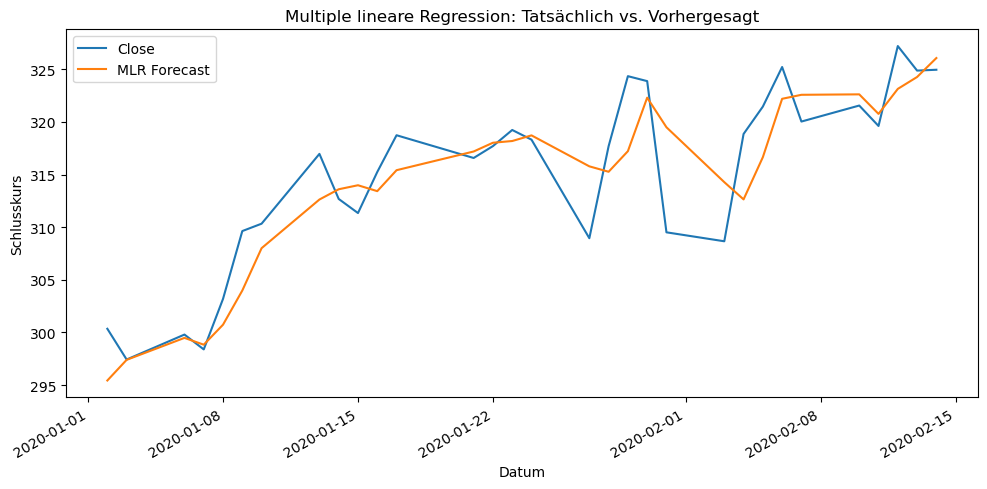

In [12]:
# Plotte die tatsächlichen Schlusskurse versus die Vorhersagen der multiplen linearen Regression
ax = df_ml.loc[start_date:end_date, ['Close', 'MLR Forecast']].plot(title='Multiple lineare Regression: Tatsächlich vs. Vorhergesagt', figsize=(10, 5))

ax.set_xlabel('Datum')
ax.set_ylabel('Schlusskurs')
ax.figure.tight_layout()

## (Optional) Lösung der Kleinste-Quadrate-Methode in der multiplen linearen Regression

In der multiplen linearen Regression versuchen wir, die Beziehung zwischen einer Zielvariablen $ y $ und mehreren Prädiktorvariablen zu modellieren. Das Modell wird allgemein ausgedrückt als:

$$
y = X \beta + \epsilon
$$

wobei:

- **$ y $** ein $ n \times 1 $ Vektor der beobachteten Werte ist (z.B. Schlusskurse).
- **$ X $** eine $ n \times p $ Matrix der Prädiktoren (Merkmale) ist, wobei jede Zeile eine Beobachtung und jede Spalte einen Prädiktor darstellt. Typischerweise enthält die erste Spalte von $ X $ Einsen, um den Interzept zu berücksichtigen.
- **$ \beta $** ein $ p \times 1 $ Vektor der Koeffizienten ist, die wir schätzen möchten.
- **$ \epsilon $** ein $ n \times 1 $ Vektor der Fehler (Residuen) ist, der den Unterschied zwischen den beobachteten und den vorhergesagten Werten darstellt.

### Zielsetzung

Das Ziel des Kleinste-Quadrate-Ansatzes ist es, den Koeffizientenvektor $ \beta $ zu finden, der die Summe der quadrierten Fehler (SSE) zwischen den beobachteten Werten und den vom Modell vorhergesagten Werten minimiert. Mathematisch lautet dieses Ziel:

$$
\min_{\beta} \| y - X \beta \|^2
$$

Dies bedeutet, dass wir die quadrierte euklidische Norm des Fehlervektors $ y - X \beta $ minimieren wollen.

### Herleitung der Kleinste-Quadrate-Lösung

Um das optimale $ \beta $ zu finden, gehen wir wie folgt vor:

1. **Formuliere die Fehlerfunktion:**  
   Die Summe der quadrierten Fehler lautet:
   $$
   S(\beta) = (y - X \beta)^T (y - X \beta)
   $$

2. **Ableitung bezüglich $ \beta $:**  
   Um $ S(\beta) $ zu minimieren, leiten wir diese Funktion nach $ \beta $ ab und setzen sie gleich Null:
   $$
   \frac{\partial S(\beta)}{\partial \beta} = -2 X^T (y - X \beta) = 0
   $$

3. **Löse die Normalengleichungen:**  
   Durch Umformen der obigen Gleichung erhalten wir die **Normalengleichungen**:
   $$
   X^T X \beta = X^T y
   $$

4. **Erhalte die Kleinste-Quadrate-Schätzung:**  
   Vorausgesetzt, dass $ X^T X $ invertierbar ist, können wir $ \beta $ berechnen:
   $$
   \beta = (X^T X)^{-1} X^T y
   $$

Diese Gleichung ist die **Kleinste-Quadrate-Lösung**. Sie liefert die Koeffizienten, die die beobachteten Daten im Sinne der Minimierung der quadrierten Fehler am besten anpassen.

## 6. Fazit

In diesem Notebook haben wir mehrere Prognoseansätze zur Vorhersage des Schlusskurses von AAPL demonstriert:

- **Naive Prognose:** Geht davon aus, dass der nächste Wert gleich dem zuletzt beobachteten Wert ist.
- **Autoregressive Prognose:** Verwendet den Durchschnitt der Schlusskurse der letzten 3 Tage.
- **Exponentielle Glättung:** Wendet einen gewichteten Durchschnitt mit einem Glättungsfaktor $\alpha$ an, um neueren Beobachtungen mehr Bedeutung beizumessen.
- **Linearer Trend:** Passt ein einfaches lineares Modell an (ein Spezialfall der linearen Regression), wobei die Zeit als Prädiktor dient.
- **Multiple lineare Regression:** Erweitert das lineare Modell durch Einbeziehung zusätzlicher Merkmale wie Handelsvolumen und eines gleitenden Durchschnitts des Schlusskurses.

Jede Methode hat ihre eigenen Annahmen und kann als Ausgangsbasis für fortgeschrittenere Prognosetechniken dienen. Durch Experimentieren mit diesen Methoden und das Abstimmen ihrer Parameter können Sie Einblicke in ihre Leistungsfähigkeit bei realen Daten gewinnen.